# Content-Based Image Retrieval
## Created by [Eva Mohedano](https://www.linkedin.com/in/eva-mohedano-261b6889/) 

##[Postgraduate Course on Artificial Intelligence with Deep Learning](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgrau-artificial-intelligence-deep-learning/). 


![alt text](https://i.ibb.co/Fh2KLPk/Screenshot-2019-05-15-at-23-40-27.png)
<center>Schematic of an image retrieval system</center>


In this session we will implement an image retrieval pipeline.
- **1 Dataset**: We will use  pytorch interface to set the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). We will make use of the pytorch [Dataset](https://pytorch.org/docs/stable/data.html) class to load the data.
- **2 Feature Extraction**. We will use the [pytorch nn.Model](https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html) interface to set the feature image extractor. We also use the pytorch [Dataloader](https://pytorch.org/docs/stable/data.html) to batch-process the images. We will consider two different feature extractors: A simple "flatten pixel model" and a siamese trained CNN (section 5).

- **3 Rank Generation**. We will make a ranked list of the relevant images of a given quey(s). For that, we will consider the cosine similarity function, sorting the obtained scored in descenting order.

- **4 Performance evaluation**. We will visualize the top ranked results for different queries, and evaluate the performance of the overall sistem computing the mAP across different image queries. The qualitative score will allow comparision between the two feature extractors considered.

---


#1-Setting the dataset


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
import torchvision
import numpy as np
from tqdm import tqdm

We will load the images using the data using the [FashionMNIST Dataset](https://pytorch.org/docs/stable/torchvision/datasets.html#fashion-mnist) interface from torchvision. 

We will apply a transformation to get the images as float tensors of size $(1, 28, 28)$ with values between $[0,1]$

In [3]:
# conversion from PIL images to pytorch Float tensor
transform = torchvision.transforms.ToTensor()

# Download and get FashionMNIST as pytorch Dataset object
ds_train = torchvision.datasets.FashionMNIST("dataset", train=True, transform=transform, target_transform=None, download=True)
ds_test = torchvision.datasets.FashionMNIST("dataset", train=False, transform=transform, target_transform=None, download=True)

0it [00:00, ?it/s]

26427392it [00:04, 6571518.46it/s]                              


Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:01, 32495.37it/s]                           
0it [00:00, ?it/s]

Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:02, 1869623.98it/s]                            
0it [00:00, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 17167.34it/s]            

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


Now, we will check the data:
* Number of samples of each partition

In [4]:
len(ds_train), len(ds_test)

(60000, 10000)

* Number of classes

In [5]:
print(len(ds_train.classes))

10


In [6]:
ds_train.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

* Visualization of data

In [7]:
# Display shape of one element, and double check min/max values, and label ID
ima, label = ds_train[0]
ima.size(), ima.min(), ima.max(), label

(torch.Size([1, 28, 28]), tensor(0.), tensor(1.), 9)

In [0]:
def display_class(ds, list_idx, id_class, n_ima, randomize=False):
  # get indices belonging to the selected class
  selected_idx = np.where(list_idx==id_class)[0]
  if randomize:
    np.random.shuffle(selected_idx)

  # print name of class
  print(f'{id_class} {ds.classes[id_class]} #images={selected_idx.shape[0]}')
  
  # display in a row
  for i, idx in enumerate(selected_idx[:n_ima]):
    subplot(1,n_ima, i+1), imshow(ds[idx][0].squeeze(), cmap='gray')
    axis('off')
  show()

100%|██████████| 60000/60000 [00:03<00:00, 15085.88it/s]


0 T-shirt/top #images=6000


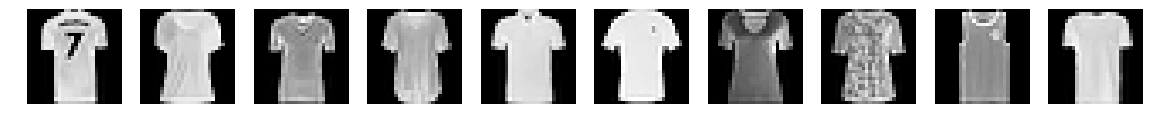

1 Trouser #images=6000


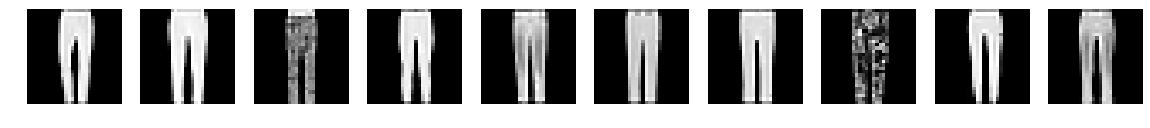

2 Pullover #images=6000


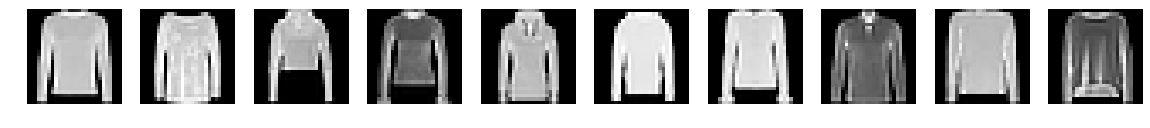

3 Dress #images=6000


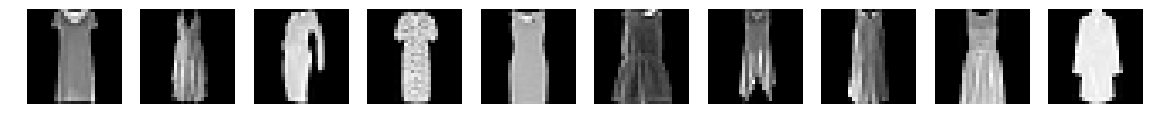

4 Coat #images=6000


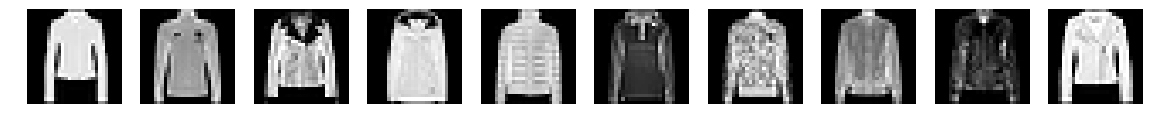

5 Sandal #images=6000


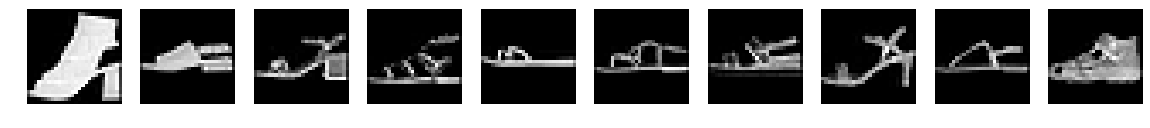

6 Shirt #images=6000


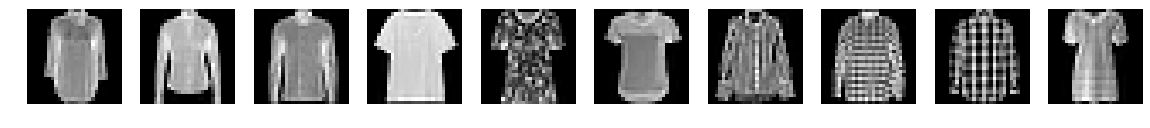

7 Sneaker #images=6000


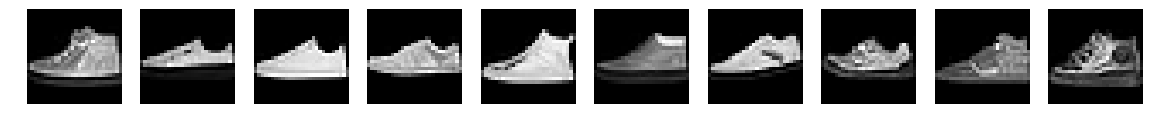

8 Bag #images=6000


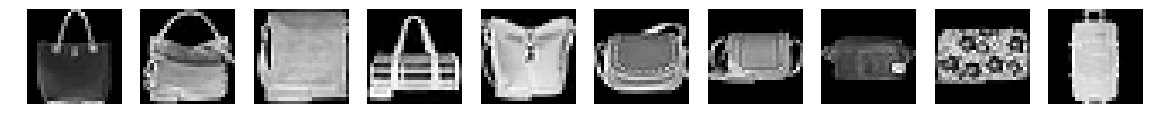

9 Ankle boot #images=6000


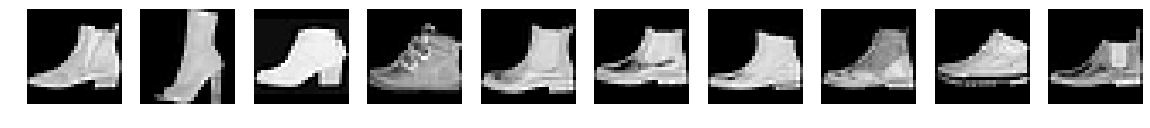

In [9]:
# Get all label ids for the training partition
list_idx = []
for i in tqdm(range(len(ds_train))):
  list_idx.append(ds_train[i][1])

list_idx = np.array(list_idx)


figsize(20,20)
for i in range(len(ds_train.classes)):
  
  display_class(ds=ds_train, list_idx=list_idx,
                id_class=i, n_ima=10, randomize=True)

Now that we have the data ready, we need to perform the feature extraction. In this case, we will directly use as image representations the **flattened pixels**.

---

#2-Feature Extractor Model

We need to define a model to extract/build our image representations for the search engine.

The easiest setup is to just use the raw pixels as image representations, and then use the cosine similarity to compare the images.

The similarity score between two image representations  $\textbf{x}$ and $\textbf{y} $ 
is given by
$$sim_{\textbf{x},\textbf{y}} = \textbf{x}\cdot \textbf{y}^T $$

If we want to obtain a bounded score between $[0,1]$ we must l2-normalize the representations:
    $$ \textbf{x}_{l_{2}norm} = \frac{\textbf{x}}{||\textbf{x}||}$$


**Exercise** Complete the feature extrator module below to extract the normalized flattened pixels

In [0]:
import torch

class Simple_Flattener_Model(torch.nn.Module):
    def __init__(self):
        super(Simple_Flattener_Model, self).__init__()

    def forward(self, x):
        """
        This model does nothing but flattening the image pixels
        and apply l2-normalization
        """
        
        # TODO:
        # flatten image pixels into a single vector

        
        # L2-normalize the representation
        return x

In [45]:
ima, label =ds_train[10]
ima.size()
ima_flat =torch.flatten(ima, start_dim=1)
ima_flat.size()

torch.Size([1, 784])

In [0]:
def extract_features(model, dataloader):
  
  FEATS = None # We collect all ds representations
  LABELS = None # And labels (for evaluation)
  
  with tqdm(total=len(dataloader)) as pbar: 
    for X in dataloader:
      ima = X[0]
      label = X[1]

      feat = model.forward(ima)
      if FEATS is None:
        FEATS = feat
        LABELS = label
      else:
        FEATS = torch.cat((FEATS,feat), dim=0)
        LABELS = torch.cat((LABELS,label), dim=0)
    pbar.update(1)

  return FEATS, LABELS

We will use the [Dataloader](https://pytorch.org/docs/stable/data.html) from pytorch to feed the images to the model, using multiple threads to load the data. We will generate a batch of $N$ images that we will feed to the model in parlalel. 


In [11]:
import torch
BATCH_SIZE = 100
WORKERS = 6
DS = ds_test

dataloader_test = torch.utils.data.DataLoader(dataset=DS, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         num_workers=WORKERS)

for X in dataloader_test:
  break
  
X[0].size(), X[1].size()

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [0]:
# Init the model
fx = Simple_Flattener_Model()

In [0]:
# Extract all test representations
X, Y = extract_features(fx, dataloader_test)
X.size(), Y.size()

----

#3-Ranking Generation

Now that we have the image representations, given an image query (represented in a same way that out dataset images), we can compare query and dataset feature representations and generate a ranked list of relevant results.


We will select a query image from the test set:

In [0]:
# make index of test images
idx = np.arange(X.size()[0])

# select randomly one
np.random.seed(1234567)
np.random.shuffle(idx)
idx_query = idx[0]

# get computed feature
q_feature = X[idx_query]

# visualize the original image
figsize(2,2)
title(f'Image Query (from class{ds_test.classes[ds_test[idx_query][1]]})')
imshow(ds_test[idx_query][0].squeeze(), cmap='gray')
axis('off')
show()

## Compute Similarities

**Exercise** Compute similarity score (dot product) between selected image query and computed representations

In [0]:
print(f'Image representation shape {q_feature.size()}')
print(f'Dataset representation shape {X.size()}')

In [0]:
similaritites = ...

**Exercise** Generated ranked results by sorting the similarity scores in descending order

In [0]:
ranked_ids = ...

#4-Qualitative Evaluation

In [0]:
figsize(20,20)
title("Top-10 most similar results")
subplot(1,11,1), imshow(ds_test[idx_query][0].squeeze(), cmap='gray')
title('QUERY')
axis('off')


for i, id in enumerate(ranked_ids[1:11]): # We disply from the second result because the query is included in the DS
  subplot(1,11,i+2), imshow(ds_test[id][0].squeeze(), cmap='gray')
  title(f'#{i+1}')
  axis('off')
  
show()

**Exercise** Visualize top 10 most different results



In [0]:
# TODO ...

---

#5-Quantitative Evaluation

We need to quantitatively asses the performance of the retrieval system. For that, we will calculate the **mean Average Precision (mAP)** of a set of queries given by
$$ mAP = \frac{1}{N}\sum_{j}^{N}\frac{1}{Q_{j}}\sum_{i=1}^{Q_{j}}P(doc_{i})$$

where $Q_{j}$ is the  number of relevant documents for query $j$, $N$ is number of queries, $P(doc_{i} )$ is the precision at $i$th relevant document. The example below ilustrates the Average Precision scores associated to the ranked retrieved results of two queries (Examples taken from [Simone Teufel lecture slides, Lecture 5: Information Retrieval](https://www.cl.cam.ac.uk/teaching/1415/InfoRtrv/lecture5.pdf))

![alt text](https://i.ibb.co/Th1hrzD/Screenshot-2019-05-13-at-23-47-01.png)


We will query all the images of the test partition within the same test partition and report the mAP score of the system.



In [0]:
def precision_at_k(r, k):
    """Score is precision @ k
    Relevance is binary (nonzero is relevant).
    >>> r = [0, 0, 1]
    >>> precision_at_k(r, 1)
    0.0
    >>> precision_at_k(r, 2)
    0.0
    >>> precision_at_k(r, 3)
    0.33333333333333331
    >>> precision_at_k(r, 4)
    Traceback (most recent call last):
        File "<stdin>", line 1, in ?
    ValueError: Relevance score length < k
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Precision @ k
    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    """Score is average precision (area under PR curve)
    Relevance is binary (nonzero is relevant).
    >>> r = [1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
    >>> delta_r = 1. / sum(r)
    >>> sum([sum(r[:x + 1]) / (x + 1.) * delta_r for x, y in enumerate(r) if y])
    0.7833333333333333
    >>> average_precision(r)
    0.78333333333333333
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Average precision
    """
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

In [0]:
def get_annotations(ds):
  list_idx = []
  for i in tqdm(range(len(ds))):
    list_idx.append(ds[i][1])

  list_idx = np.array(list_idx)
  
  return list_idx

def evaluate_mAP(feats, ds, N=-1, random_seed=1234):
  # all similarities
  all_sim = torch.mm(feats, feats.t())
  
  # all ranked lists
  all_ranked = torch.sort(all_sim, descending=True).indices
  all_ranked = all_ranked.numpy()
  
  # get annotations
  annotations = get_annotations(ds)

  all_ap = []
  
  # set random seed
  idx = np.arange(len(ds))
  np.random.seed(random_seed)
  np.random.shuffle(idx)
  
  if N>-1:
    idx = idx[:N]

  for k, i in enumerate(idx):
    # get ID query
    id_query = ds[i][1]
    
    # build list of relevant ids 
    gt = np.zeros_like(annotations)
    gt[annotations[all_ranked[i,...]]==id_query]=1 # set1 positions of rel.class
    
    # compute ap
    ap = average_precision(gt)

    all_ap.append(ap)
    if k % 100 ==0:
      print(f'{k}, Query {i}\t{ds_test.classes[id_query]}\t AP={ap}')

  return all_ap

In [0]:
# evaluation over 1000 randomly selected queries from the test partition
all_ap = evaluate_mAP(X, ds_test, N=1000)
print(f'Mean AP={np.mean(all_ap)}')

100%|██████████| 10000/10000 [00:00<00:00, 14100.37it/s]


0, Query 2374	T-shirt/top	 AP=0.6489748490172064
100, Query 8528	Bag	 AP=0.4333801139718147
200, Query 8258	Coat	 AP=0.5252787342468368
300, Query 6937	Trouser	 AP=0.8481704759108838
400, Query 2287	Ankle boot	 AP=0.43860900983813733
500, Query 3252	Sneaker	 AP=0.5845462963531447
600, Query 4528	Sneaker	 AP=0.8753465825067172
700, Query 6925	Bag	 AP=0.36014006194641784
800, Query 8281	Sandal	 AP=0.10489960642974583
900, Query 6167	Trouser	 AP=0.8999701160353883
Mean AP=0.48285201042281245


-----

#6-Siamese CNN network

In this section will trained a siamese CNN network on positivs and negative pairs generated from the Fashion MNIST. We will use the cosine distance $D_{cosine} = 1-\textbf{x}_{1}\cdot \textbf{x}_{2}$. The CNN generates l2-normalized embeddings.

![alt text](https://i.ibb.co/DGFHsn3/Screenshot-2019-05-16-at-00-31-26.png)

We need to generate pairs of images that we will associate to a label: $1$ if they represent the same class, $0$ if they represent different classes.

In [0]:
def create_pairs(digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs.append((z1, z2))
            idx_tmp = np.arange(1,10)
            np.random.shuffle(idx_tmp)
            inc = idx_tmp[0]
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs.append((z1, z2))
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [0]:
from torch.utils.data import Dataset

class ImagePair(Dataset):
  """Image Pair Pytorch Dataset"""

  def __init__(self, mode='train', negative_n_label=False):
    """
    The constructor initializes original MNIST training dataset 
    and generate a list of similar/disimilar tuples

    """

    # We will re-use the original Dataset
    transform = torchvision.transforms.ToTensor()
    self.ds_image = torchvision.datasets.FashionMNIST("dataset", 
                                                      train=True, 
                                                      transform=transform)
    
    self.negative_n_label = negative_n_label
    
    y_train = get_annotations(self.ds_image)
    digit_indices = [np.where(y_train == i)[0] for i in range(10)]

    # get the pairs
    pairs, labels = create_pairs( digit_indices)


    # shuffle order
    idx = np.arange(pairs.shape[0])
    np.random.seed(1234)
    np.random.shuffle(idx)
    
    pairs = pairs[idx, :]
    labels = labels[idx]
    
    
    # we take the 80% original data for training
    N = int(0.8*pairs.shape[0])
    if mode == "train":
      self.pairs = pairs[:N,:]
      self.labels = labels[:N]
    else:
      self.pairs = pairs[N:,:]
      self.labels = labels[N:]
      

  def __len__(self):
    return self.pairs.shape[0]

  def __getitem__(self, idx):
    id1, id2 = self.pairs[idx, :]
    l = self.labels[idx]
    if l ==0 and self.negative_n_label:
      l=-1
    
    x1 = self.ds_image[id1][0]
    x2 = self.ds_image[id2][0]
    
    return x1, x2, l

In [17]:
# Init dataset
ds_pairs_train = ImagePair(mode='train', negative_n_label=True)
ds_pairs_val = ImagePair(mode='val', negative_n_label=True)

len(ds_pairs_train), len(ds_pairs_val)

100%|██████████| 60000/60000 [00:04<00:00, 14813.42it/s]


(95984, 23996)

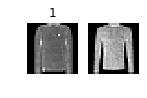

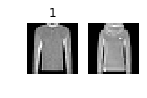

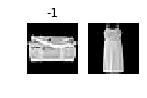

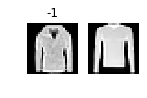

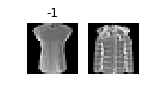

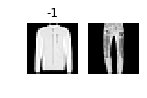

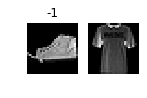

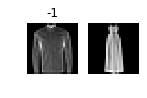

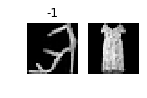

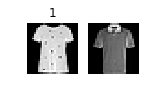

In [18]:
# Check inputs
idx = np.arange(len(ds_pairs_train))
np.random.shuffle(idx)
for i in idx[:10]:
  x1, x2, l = ds_pairs_train[i]

  figsize(2,2)
  subplot(1,2,1), imshow(x1.squeeze(), cmap='gray')
  axis('off')
  title(l)

  subplot(1,2,2), imshow(x2.squeeze(), cmap='gray')
  axis('off')
  show()

In [19]:
len(ds_pairs_train), len(ds_pairs_val)

(95984, 23996)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

def l2norm(x):
  x = x / torch.sqrt(torch.sum(x**2, dim=-1, keepdim=True))
  return x

      
class ConvNet(nn.Module):
    def __init__(self, dim_embedding=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, dim_embedding)
        
    def forward(self, X):
        x1 = X[0]
        x2 = X[1]
        
        out1 = self.layer1(x1)
        out1 = self.layer2(out1)
        out1 = out1.reshape(out1.size(0), -1)
        out1 = self.fc(out1)
        out1 = l2norm(out1)
        
        
        out2 = self.layer1(x2)
        out2 = self.layer2(out2)
        out2 = out2.reshape(out2.size(0), -1)
        out2 = self.fc(out2)
        out2 = l2norm(out2)
        
        return out1, out2
      
    def extract_feature(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        x = l2norm(x)
        
        return x

In [0]:
BATCH_SIZE = 128
WORKERS = 6

dataloader ={
    'train': torch.utils.data.DataLoader(dataset=ds_pairs_train, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=True, 
                                         num_workers=WORKERS),
    'val': torch.utils.data.DataLoader(dataset=ds_pairs_val, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=False, 
                                     num_workers=WORKERS)}


In [24]:
model = ConvNet(dim_embedding=100).cuda()


lr = 0.01
num_epochs = 10
weight_decay = 0.0001

optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

cosine_embedding_loss = nn.CosineEmbeddingLoss(margin=0.5).cuda()

loss_epoch_train = []
loss_epoch_val = []

for epoch in range(num_epochs):
  
  # update lr
  if epoch>0 and epoch %10==0:
    for g in optimizer.param_groups:
      g['lr'] *=0.1
      print("update lr")
  for mode in ['train', 'val']:
    all_loss = []
    for i, X in enumerate(dataloader[mode]):
      if mode =='val':
        model = model.eval()
      else:
        model = model.train()
        
      x1, x2, label = X
      x1 = x1.cuda()
      x2 = x2.cuda()
      label = label.float().cuda()

      out1, out2 = model.forward((x1,x2))
      
      loss = cosine_embedding_loss(out1, out2, label)      
      
      if mode =='train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      all_loss.append(loss.item())


    av_loss = np.mean(all_loss)
    if mode == 'train':
      loss_epoch_train.append(av_loss)
      print(f'TRAIN Epoch:{epoch} - Loss:{av_loss}')
    else:
      loss_epoch_val.append(av_loss)
      print(f'VAL Epoch:{epoch} - Loss:{av_loss}')
      

TRAIN Epoch:0 - Loss:0.12321529786785444
VAL Epoch:0 - Loss:0.10766040078027451
TRAIN Epoch:1 - Loss:0.10393932485580444
VAL Epoch:1 - Loss:0.09912405484058756


KeyboardInterrupt: ignored

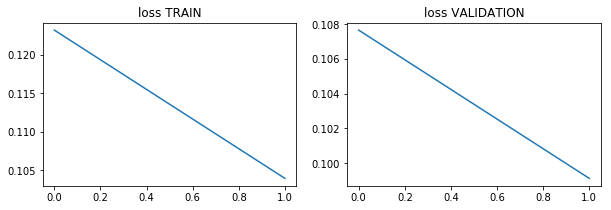

In [25]:
figsize(10,3)
subplot(1,2,1), plot(loss_epoch_train)
title('loss TRAIN')

subplot(1,2,2), plot(loss_epoch_val)
title('loss VALIDATION')
show()

In [26]:
def extract_features(model, dataloader):
  
  FEATS = None # We collect all ds representations
  LABELS = None # And labels (for evaluation)
  
  with tqdm(total=len(dataloader)) as pbar: 
    for X in dataloader:
      ima = X[0].cuda()
      label = X[1].cuda()

      feat = model.extract_feature(ima)
      if FEATS is None:
        FEATS = feat
        LABELS = label
      else:
        FEATS = torch.cat((FEATS,feat), dim=0)
        LABELS = torch.cat((LABELS,label), dim=0)
    pbar.update(1)

  return FEATS, LABELS

# Extract all test representations
X, Y = extract_features(model, dataloader_test)
X.size(), Y.size()

  1%|          | 1/100 [00:00<01:28,  1.12it/s]


(torch.Size([10000, 100]), torch.Size([10000]))

In [27]:
X = X.data.cpu()

all_ap = evaluate_mAP(X, ds_test, N=1000)
print(f'Mean AP={np.mean(all_ap)}')

# all_ap = evaluate_mAP(X, ds_test)
# print(f'Mean AP={np.mean(all_ap)}')

100%|██████████| 10000/10000 [00:00<00:00, 14655.32it/s]


NameError: ignored


**Exercise** Improve the mAP! Experiment with different network configurations (i.q More/less layers, different embedding size), longer training, vary learning rate to see if you can boost the obtained results.

| Feature Extractor       |  mAP |
| ------------- |:------------ -----:|
|Flatten l2norm raw pixels |  <center>0.479 <center> |
|Siamese CNN baseline|  <center>0.667 <center> |
|Siamese CNN - super tuning version | <center>?? <center>|
  
  ---

#7-[extra]Query an external dataset image

In [28]:
! wget https://refreshoes.com/20843-home_default/bolso-de-mujer-refresh-083186.jpg

--2019-05-16 18:56:33--  https://refreshoes.com/20843-home_default/bolso-de-mujer-refresh-083186.jpg
Resolving refreshoes.com (refreshoes.com)... 51.75.156.116
Connecting to refreshoes.com (refreshoes.com)|51.75.156.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30055 (29K) [image/jpeg]
Saving to: ‘bolso-de-mujer-refresh-083186.jpg’

bolso-de-mujer-refr 100%[===================>]  29.35K   123KB/s    in 0.2s    

2019-05-16 18:56:34 (123 KB/s) - ‘bolso-de-mujer-refresh-083186.jpg’ saved [30055/30055]



In [0]:
from skimage import io, transform

In [33]:
from PIL import Image
image = Image.open('bolso-de-mujer-refresh-083186.jpg')
image = image.convert('L')
image, image.size

(<PIL.Image.Image image mode=L size=500x600 at 0x7FFA7E5ED358>, (500, 600))

In [35]:
image = torchvision.transforms.Resize((28,28))(image)
image = torchvision.transforms.ToTensor()(image)
image.size()

torch.Size([1, 28, 28])

In [0]:
query = model.extract_feature(image[None,...].cuda())

In [0]:
similaritites = torch.mm(query, X.t().cuda()).squeeze()

In [0]:
ranked_ids = torch.sort(similaritites, descending=True).indices.data.cpu().numpy()

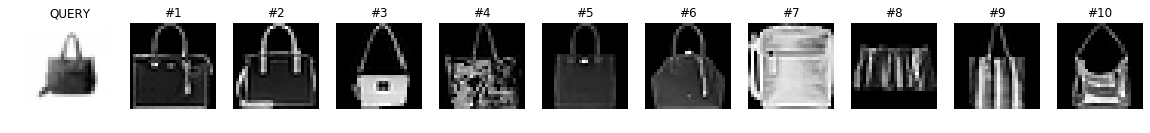

In [39]:
figsize(20,20)
title("Top-10 most similar results")
subplot(1,11,1), imshow(image.squeeze(), cmap='gray')
title('QUERY')
axis('off')


for i, id in enumerate(ranked_ids[:10]): # We display from the second result because the query is included in the DS
  subplot(1,11,i+2), imshow(ds_test[id][0].squeeze(), cmap='gray')
  title(f'#{i+1}')
  axis('off')
  
show()

<center> The End :) <center>